<center><h1>Gunadi_Eben_HW5</h1></center>
<br>
<br>

Name: Eben Gunadi
<br>
Github Username: egunadi
<br>
USC ID: 3976793880

## 1. Decision Trees as Interpretable Models

Import packages

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import _tree
from graphviz import Source
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

### (a) Obtain Data

Get the Accute Inamations Data Set

In [46]:
diagnosis_filepath = '../data/diagnosis.data.csv'

diagnosis_headers = ['Temperature', 
                     'Nausea', 
                     'LumbarPain', 
                     'UrinePushing', 
                     'MicturitionPains', 
                     'UrethraBurning', 'UrinaryBladderInflammation', 'RenalPelvisNephritis']

diagnosis_df = pd.read_csv(diagnosis_filepath, delimiter='\t', encoding='utf-8', names=diagnosis_headers)

In [47]:
diagnosis_df['Temperature'] = diagnosis_df['Temperature'].str.replace(',', '.').astype(float)

In [48]:
diagnosis_df['Nausea'] = diagnosis_df['Nausea'].map({'yes': True, 'no': False})
diagnosis_df['LumbarPain'] = diagnosis_df['LumbarPain'].map({'yes': True, 'no': False})
diagnosis_df['UrinePushing'] = diagnosis_df['UrinePushing'].map({'yes': True, 'no': False})
diagnosis_df['MicturitionPains'] = diagnosis_df['MicturitionPains'].map({'yes': True, 'no': False})
diagnosis_df['UrethraBurning'] = diagnosis_df['UrethraBurning'].map({'yes': True, 'no': False})
diagnosis_df['UrinaryBladderInflammation'] = diagnosis_df['UrinaryBladderInflammation'].map({'yes': True, 'no': False})
diagnosis_df['RenalPelvisNephritis'] = diagnosis_df['RenalPelvisNephritis'].map({'yes': True, 'no': False})

In [49]:
diagnosis_df.head()

,Temperature,Nausea,LumbarPain,UrinePushing,MicturitionPains,UrethraBurning,UrinaryBladderInflammation,RenalPelvisNephritis
0,35.5,False,True,False,False,False,False,False
1,35.9,False,False,True,True,True,True,False
2,35.9,False,True,False,False,False,False,False
3,36.0,False,False,True,True,True,True,False
4,36.0,False,True,False,False,False,False,False


In [50]:
diagnosis_df.shape

(120, 8)

### (b) Build a decision tree

In [51]:
# Build a decision tree on the whole data set and plot it. 
# Per question@317 in Piazza, first build two decision tree, one more each of the two target variables

X_diagnosis = diagnosis_df.drop(columns=['UrinaryBladderInflammation', 'RenalPelvisNephritis'])
y1_diagnosis = diagnosis_df['UrinaryBladderInflammation']
y2_diagnosis = diagnosis_df['RenalPelvisNephritis']

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf1.fit(X_diagnosis, y1_diagnosis)

tree_clf2 = DecisionTreeClassifier(random_state=42)
tree_clf2.fit(X_diagnosis, y2_diagnosis)

DecisionTreeClassifier(random_state=42)

In [52]:
export_graphviz(
    tree_clf1,
    out_file='diagnosis_tree1.dot',
    feature_names=X_diagnosis.columns,
    class_names=['False', 'True'],
    rounded=True,
    filled=True
)

export_graphviz(
    tree_clf2,
    out_file='diagnosis_tree2.dot',
    feature_names=X_diagnosis.columns,
    class_names=['False', 'True'],
    rounded=True,
    filled=True
)

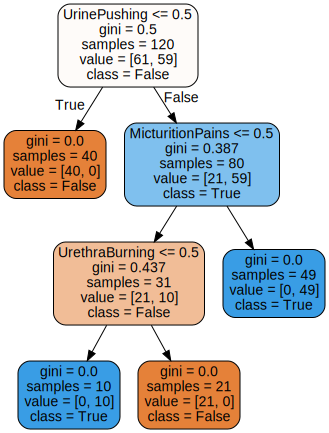

In [53]:
Source.from_file('diagnosis_tree1.dot')

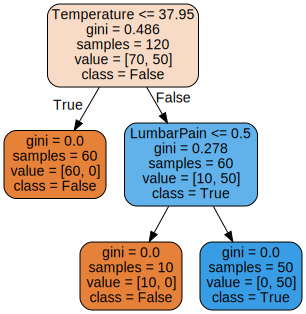

In [54]:
Source.from_file('diagnosis_tree2.dot')

In [55]:
# Next, build a decision tree for both target variables at the same time

y_diagnosis = diagnosis_df[['UrinaryBladderInflammation', 'RenalPelvisNephritis']]

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_diagnosis, y_diagnosis)

DecisionTreeClassifier(random_state=42)

In [56]:
export_graphviz(
    tree_clf,
    out_file="diagnosis_tree.dot",
    feature_names=X_diagnosis.columns,
    class_names=y_diagnosis.columns,
    rounded=True,
    filled=True
)

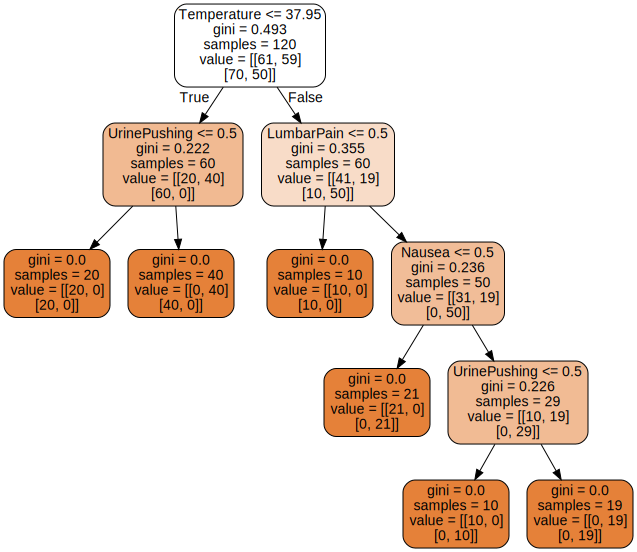

In [57]:
Source.from_file("diagnosis_tree.dot")

### (c) Convert the decision rules

In [58]:
# Convert the decision rules into a set of IF-THEN rules

def tree_to_code(tree, feature_names):
	"""
	Outputs a decision tree model as a Python function
	
	Parameters:
	-----------
	tree: decision tree model
		The decision tree to represent as a function
	feature_names: list
		The feature names of the dataset used for building the decision tree
	"""

	tree_ = tree.tree_
	feature_name = [
		feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
		for i in tree_.feature
	]
	print("def tree({}):".format(", ".join(feature_names)))

	def recurse(node, depth):
		indent = "  " * depth
		if tree_.feature[node] != _tree.TREE_UNDEFINED:
			name = feature_name[node]
			threshold = tree_.threshold[node]
			print("{}if {} <= {}:".format(indent, name, threshold))
			recurse(tree_.children_left[node], depth + 1)
			print("{}else:  # if {} > {}".format(indent, name, threshold))
			recurse(tree_.children_right[node], depth + 1)
		else:
			print("{}return {}".format(indent, tree_.value[node]))

	recurse(0, 1)

In [59]:
tree_to_code(tree_clf, list(X_diagnosis.columns))

def tree(Temperature, Nausea, LumbarPain, UrinePushing, MicturitionPains, UrethraBurning):
  if Temperature <= 37.95000076293945:
    if UrinePushing <= 0.5:
      return [[20.  0.]
 [20.  0.]]
    else:  # if UrinePushing > 0.5
      return [[ 0. 40.]
 [40.  0.]]
  else:  # if Temperature > 37.95000076293945
    if LumbarPain <= 0.5:
      return [[10.  0.]
 [10.  0.]]
    else:  # if LumbarPain > 0.5
      if Nausea <= 0.5:
        return [[21.  0.]
 [ 0. 21.]]
      else:  # if Nausea > 0.5
        if UrinePushing <= 0.5:
          return [[10.  0.]
 [ 0. 10.]]
        else:  # if UrinePushing > 0.5
          return [[ 0. 19.]
 [ 0. 19.]]


### (d) Cost complexity pruning

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_diagnosis, y_diagnosis, test_size=0.2, random_state=42)

path = tree_clf.cost_complexity_pruning_path(X_diagnosis, y_diagnosis)
alphas = path['ccp_alphas']

accuracy_train = []
accuracy_test = []
for alpha in alphas:
    pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)

    pruned_tree.fit(X_train, y_train)
    y_train_pred = pruned_tree.predict(X_train)
    y_test_pred = pruned_tree.predict(X_test)

    accuracy_train.append(accuracy_score(y_train, y_train_pred))
    accuracy_test.append(accuracy_score(y_test, y_test_pred))

/Users/ebengunadi/anaconda3/envs/dsci552-hw5/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ebengunadi/anaconda3/envs/dsci552-hw5/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ebengunadi/anaconda3/envs/dsci552-hw5/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ebengunadi/anaconda3/envs/dsci552-hw5/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning

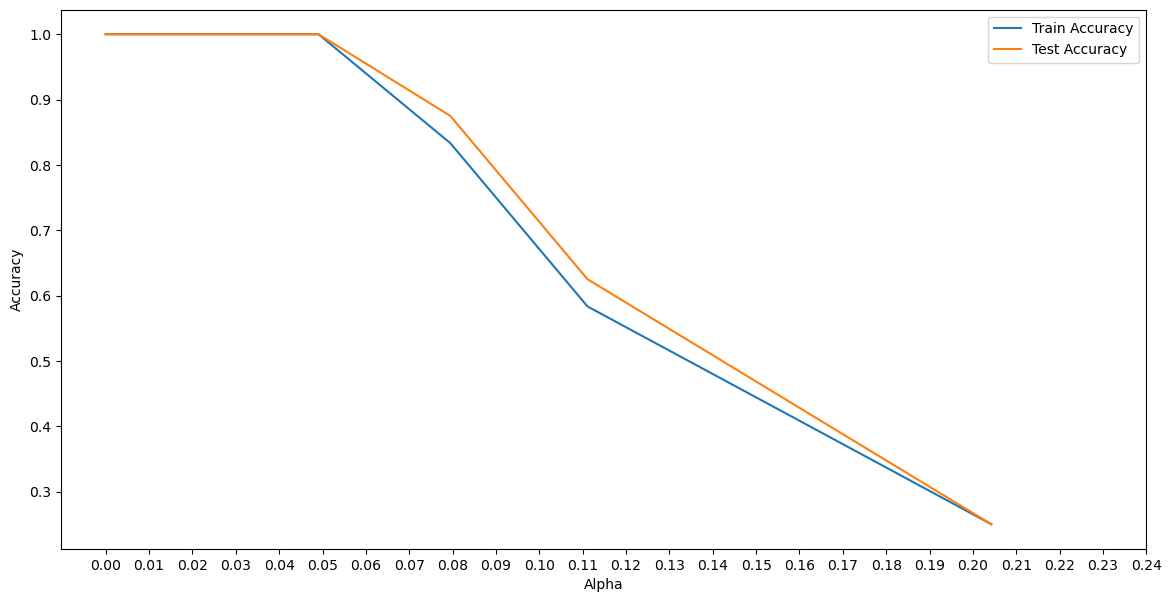

In [61]:
plt.figure(figsize=(14,7))
sns.lineplot(y=accuracy_train, x=alphas, label='Train Accuracy')
sns.lineplot(y=accuracy_test, x=alphas, label='Test Accuracy')
plt.xticks(ticks=np.arange(0.00, 0.25, 0.01))
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.show()

From the above plot, alpha <= 0.05 gives the best accuracy. Will select 0.05 since bigger alphas lead to more interpretable models.

In [62]:
best_tree_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=0.05)
best_tree_clf.fit(X_diagnosis, y_diagnosis)

DecisionTreeClassifier(ccp_alpha=0.05, random_state=42)

In [63]:
export_graphviz(
    best_tree_clf,
    out_file="best_diagnosis_tree.dot",
    feature_names=X_diagnosis.columns,
    class_names=y_diagnosis.columns,
    rounded=True,
    filled=True
)

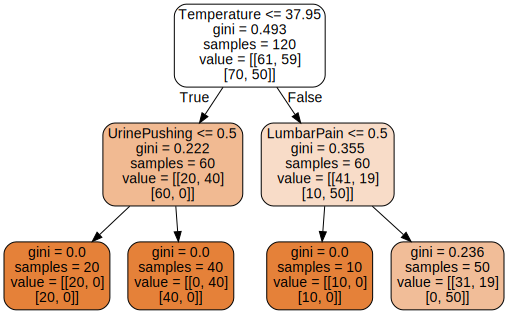

In [64]:
Source.from_file("best_diagnosis_tree.dot")

In [65]:
tree_to_code(best_tree_clf, list(X_diagnosis.columns))

def tree(Temperature, Nausea, LumbarPain, UrinePushing, MicturitionPains, UrethraBurning):
  if Temperature <= 37.95000076293945:
    if UrinePushing <= 0.5:
      return [[20.  0.]
 [20.  0.]]
    else:  # if UrinePushing > 0.5
      return [[ 0. 40.]
 [40.  0.]]
  else:  # if Temperature > 37.95000076293945
    if LumbarPain <= 0.5:
      return [[10.  0.]
 [10.  0.]]
    else:  # if LumbarPain > 0.5
      return [[31. 19.]
 [ 0. 50.]]


## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [66]:
communities_filepath = '../data/communities.data.csv'

communities_headers = ['state', 'county', 'community', 'communityname', 'fold', 'population', 'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PctLargHouseOccup', 'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctHousOwnOcc', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'OwnOccMedVal', 'OwnOccHiQuart', 'RentLowQ', 'RentMedian', 'RentHighQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn', 'PctBornSameState', 'PctSameHouse85', 'PctSameCity85', 'PctSameState85', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn', 'PolicBudgPerPop', 'ViolentCrimesPerPop']

communities_df = pd.read_csv(communities_filepath, delimiter=',', encoding='utf-8', names=communities_headers, na_values='?')

In [67]:
communities_df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


In [68]:
communities_df.shape

(1994, 128)

In [69]:
# Use the first 1495 rows of data as the training set and the rest as the test set.

communities_train_df = communities_df.iloc[:1495, :]
communities_test_df = communities_df.iloc[1495:, :]

### (b) Missing values

In [70]:
# The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

non_predictive_features = ['state', 'county', 'community', 'communityname', 'fold']
communities_train_df = communities_train_df.drop(columns=non_predictive_features)
communities_test_df = communities_test_df.drop(columns=non_predictive_features)

communities_train_df = communities_train_df.fillna(communities_train_df.mean())
communities_test_df = communities_test_df.fillna(communities_test_df.mean())

In [71]:
communities_train_df.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03


In [72]:
communities_test_df.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
1495,0.00,0.20,0.03,0.91,0.23,0.05,0.15,0.19,0.09,0.42,...,0.01,0.23,0.73,0.1605,0.065375,0.655375,0.40625,0.0,0.208,0.12
1496,0.00,0.55,0.13,0.78,0.15,0.36,0.48,0.53,0.30,0.10,...,0.01,0.18,0.02,0.1605,0.065375,0.655375,0.40625,0.0,0.208,0.11
1497,0.00,0.52,0.04,0.59,0.05,0.62,0.84,0.78,0.75,0.43,...,0.01,0.18,0.00,0.1605,0.065375,0.655375,0.40625,0.0,0.208,0.12
1498,0.04,0.51,0.07,0.92,0.09,0.03,0.38,0.47,0.27,0.35,...,0.06,0.13,0.16,0.1605,0.065375,0.655375,0.40625,0.0,0.208,0.06
1499,0.03,0.59,0.20,0.75,0.19,0.10,0.38,0.62,0.35,0.11,...,0.03,0.23,0.06,0.1605,0.065375,0.655375,0.40625,0.0,0.208,0.12


In [73]:
print(communities_train_df.shape)
print(communities_test_df.shape)

(1495, 123)
(499, 123)


### (c) Plot a correlation matrix

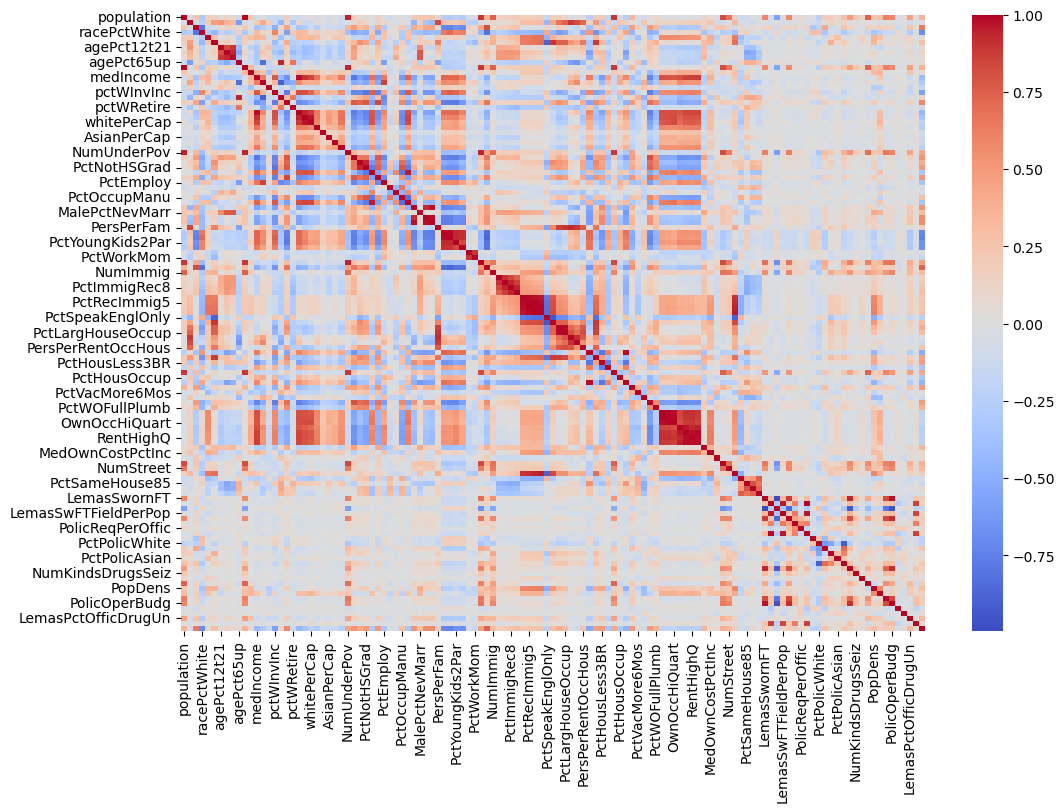

In [74]:
corr_matrix = communities_train_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

### (d) Calculate the Coefficient of Variation CV

In [75]:
# Calculate the Coefficient of Variation CV for each feature, where CV = s/m , in which s is sample standard deviation and m is sample mean

cv = communities_train_df.std() / communities_train_df.mean()
cv.sort_values(ascending=False)

NumStreet              4.292923
NumInShelters          3.470952
NumIlleg               3.058964
NumImmig               2.926635
LemasPctOfficDrugUn    2.552946
                         ...   
NumKindsDrugsSeiz      0.144382
RacialMatchCommPol     0.134853
PctPolicWhite          0.122813
LemasPctPolicOnPatr    0.115739
LemasSwFTFieldOps      0.064288
Length: 123, dtype: float64

### (e) Scatter plots and box plots for highest CV features

In [76]:
# Pick √128 features with highest CV, and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

cv_features = cv.sort_values(ascending=False).head(11).index
cv_features

Index(['NumStreet', 'NumInShelters', 'NumIlleg', 'NumImmig',
       'LemasPctOfficDrugUn', 'NumUnderPov', 'population', 'numbUrban',
       'HousVacant', 'LandArea', 'racePctHisp'],
      dtype='object')

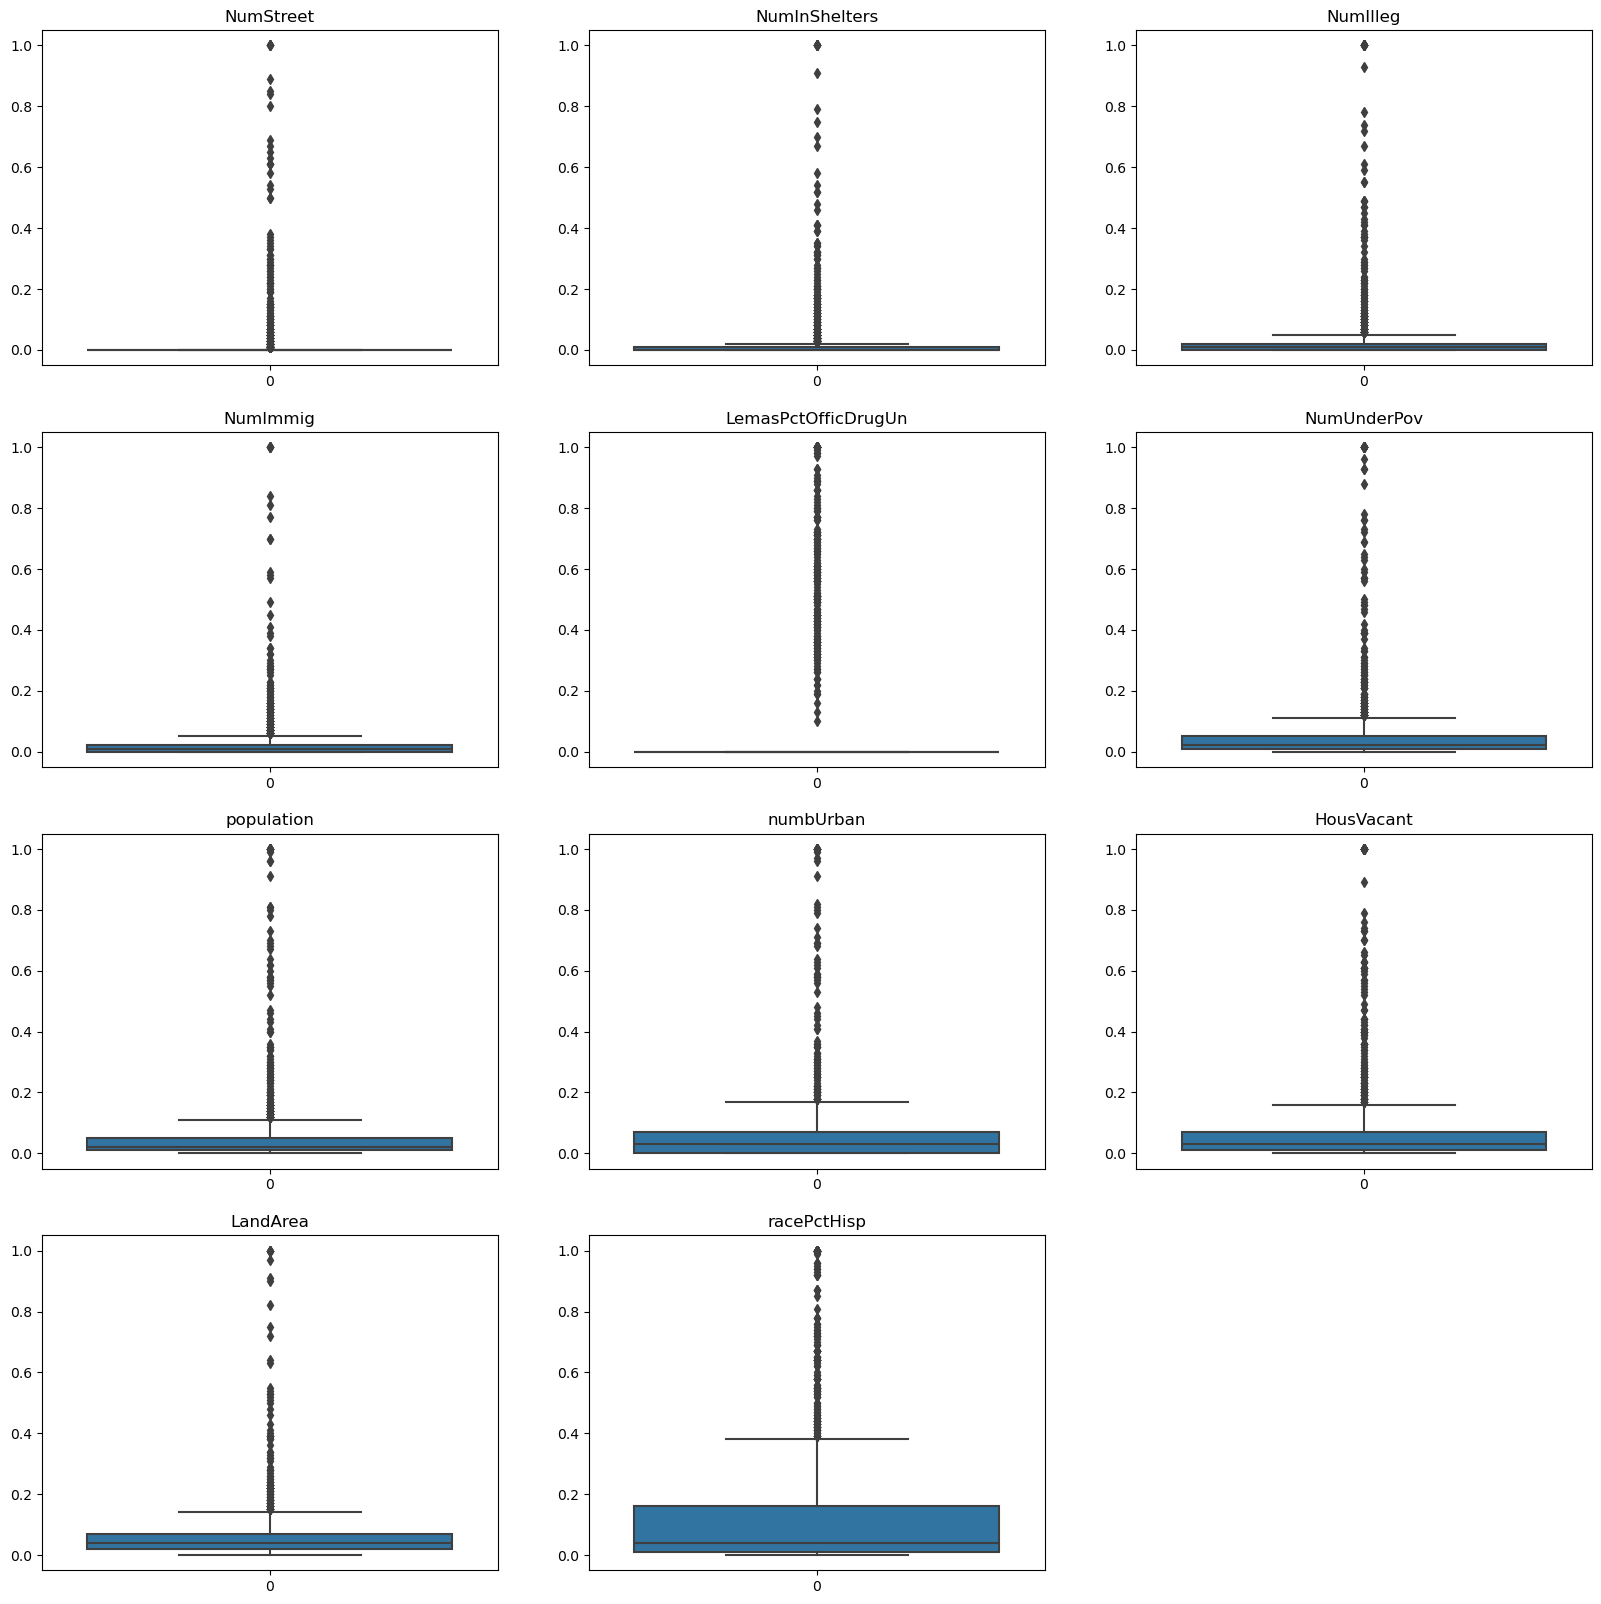

In [77]:
plt.figure(figsize=(20, 20))
for i, feature in enumerate(cv_features):
    plt.subplot(4, 3, i+1)
    sns.boxplot(communities_train_df[feature])
    plt.title(feature)
plt.show()

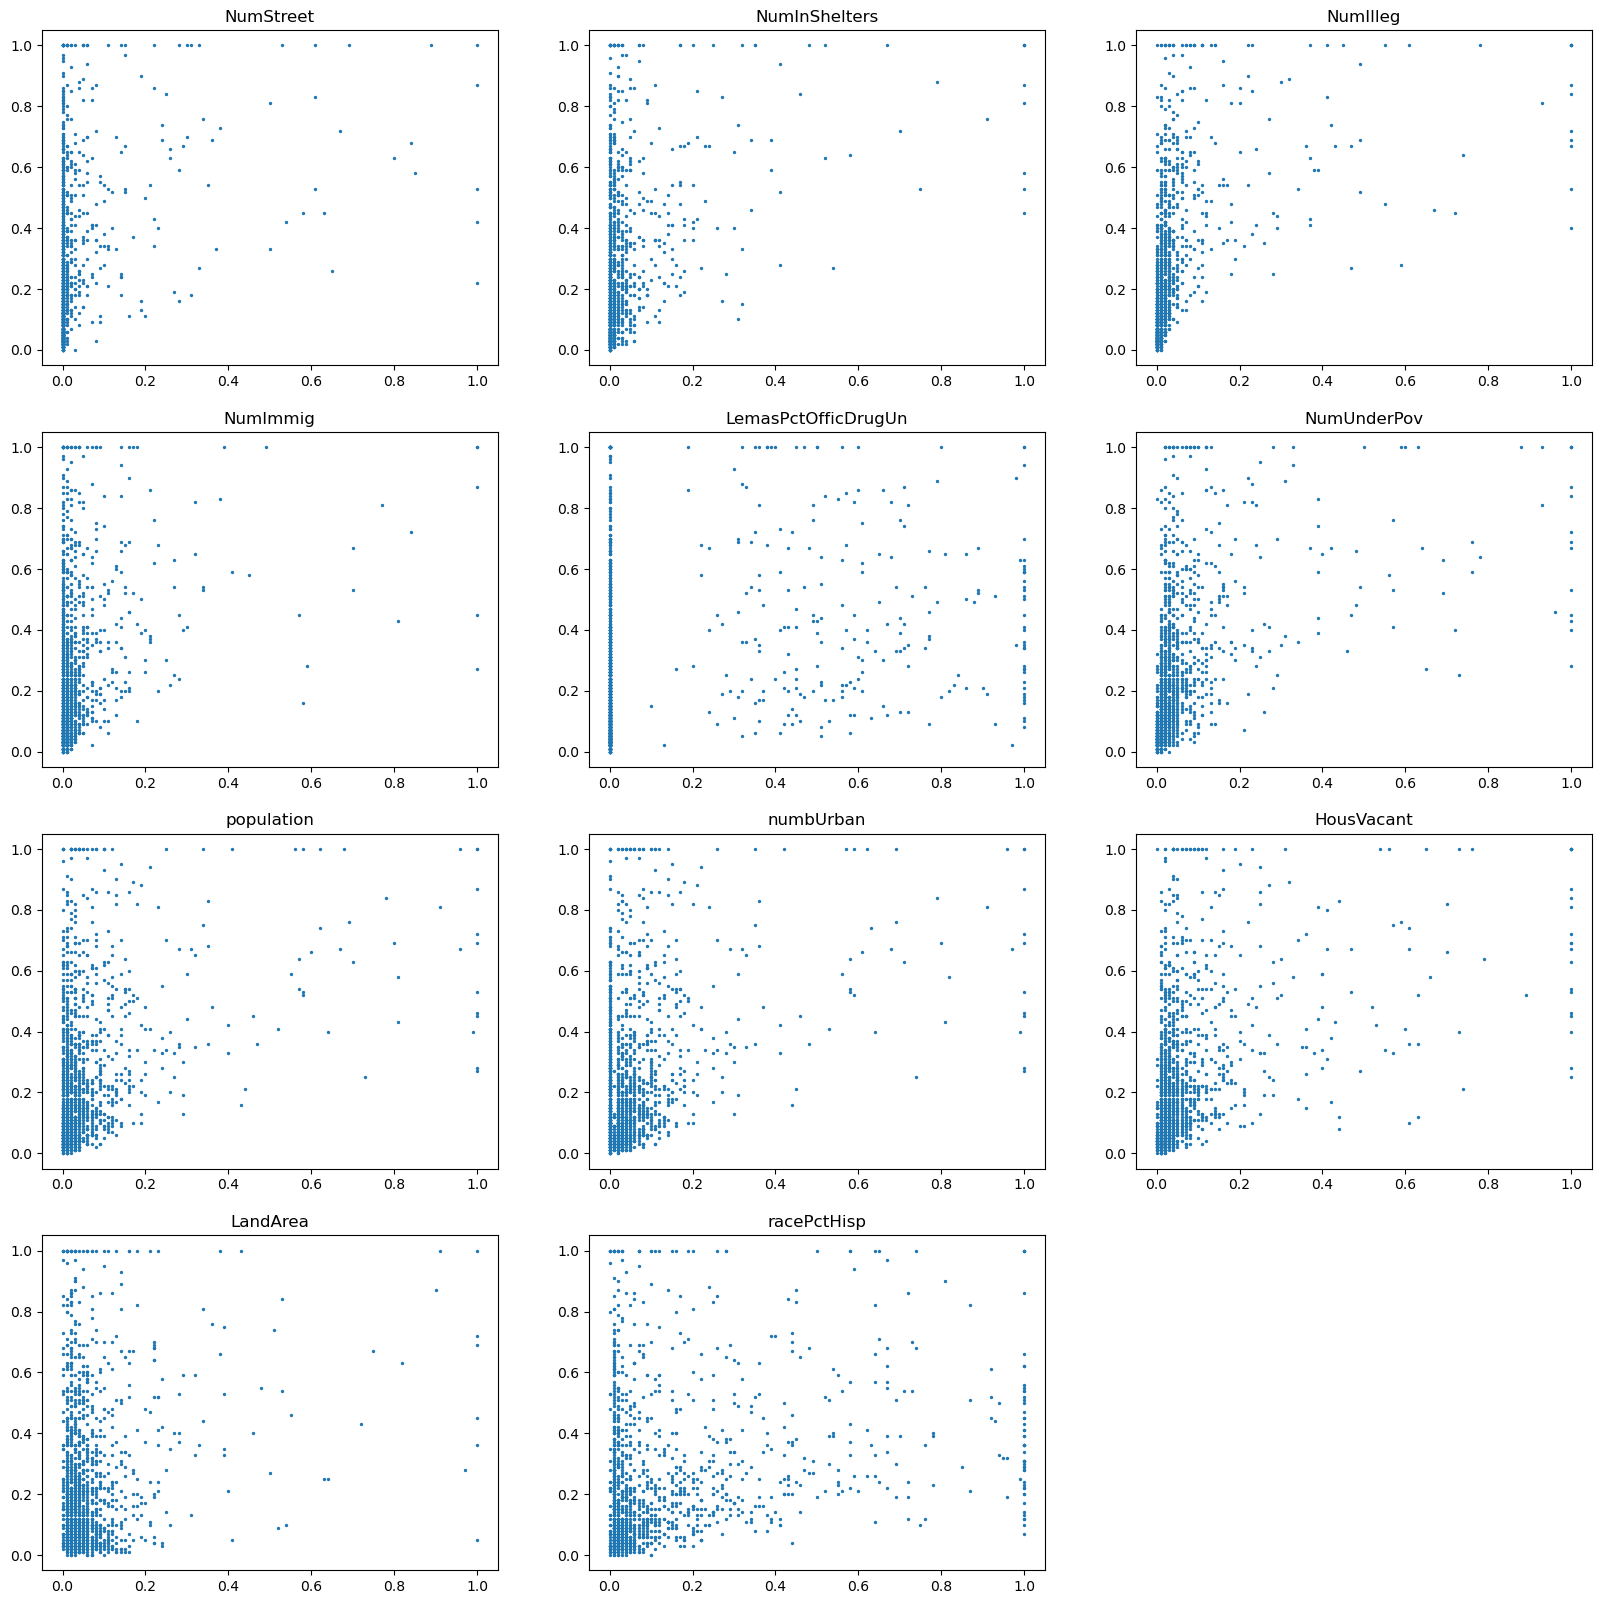

In [78]:
plt.figure(figsize=(20, 20))
for i, feature in enumerate(cv_features):
    plt.subplot(4, 3, i+1)
    plt.scatter(communities_train_df[feature], communities_train_df['ViolentCrimesPerPop'], s=2)
    plt.title(feature)
plt.show()

Based on the scatter plots, there doesn't seem to be a strong correlation between these high variance features and `ViolentCrimesPerPop`.

### (f) Fit a linear model

In [79]:
# Fit a linear model using least squares to the training set and report the test error.

X_train = communities_train_df.drop(columns=['ViolentCrimesPerPop'])
y_train = communities_train_df['ViolentCrimesPerPop']
X_test = communities_test_df.drop(columns=['ViolentCrimesPerPop'])
y_test = communities_test_df['ViolentCrimesPerPop']

# Fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict on test set
y_test_pred = lin_reg.predict(X_test)

# Calculate test error
lin_reg_mse = mean_squared_error(y_test, y_test_pred)
print(f'Test error for linear regression: {lin_reg_mse:.1f}')

Test error for linear regression: 19284897370096072.0


### (g) Fit a ridge regression model

In [80]:
# Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

# Fit ridge regression with cross-validated lambda
ridge_reg = RidgeCV(cv=5, scoring='neg_mean_squared_error')
ridge_reg.fit(X_train, y_train)

# Predict on test set 
y_pred = ridge_reg.predict(X_test)

# Calculate test error
ridge_mse = mean_squared_error(y_test, y_pred)
print(f'Test error for ridge regression: {ridge_mse:.3f}')

Test error for ridge regression: 0.018


### (h) Fit a LASSO model

In [81]:
# Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

# Fit LASSO with cross-validated lambda
lasso_reg = LassoCV(cv=5)
lasso_reg.fit(X_train, y_train)

# Predict on test set
y_pred = lasso_reg.predict(X_test)

# Calculate test error
lasso_mse = mean_squared_error(y_test, y_pred)
print(f'Test error for LASSO regression: {lasso_mse:.3f}')

Test error for LASSO regression: 0.018


/Users/ebengunadi/anaconda3/envs/dsci552-hw5/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009752930225641165, tolerance: 0.006746416078595318
  model = cd_fast.enet_coordinate_descent_gram(
/Users/ebengunadi/anaconda3/envs/dsci552-hw5/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010113610154370178, tolerance: 0.006746416078595318
  model = cd_fast.enet_coordinate_descent_gram(


In [82]:
lasso_features = X_train.columns[lasso_reg.coef_ != 0]
lasso_features

Index(['racepctblack', 'racePctAsian', 'agePct12t21', 'agePct12t29',
       'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec',
       'pctWPubAsst', 'pctWRetire', 'whitePerCap', 'blackPerCap',
       'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap',
       'PctPopUnderPov', 'PctLess9thGrade', 'PctEmploy', 'PctEmplManu',
       'PctOccupManu', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv',
       'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMom',
       'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRec10', 'PctRecImmig10',
       'PctNotSpeakEnglWell', 'PctLargHouseOccup', 'PersPerOccupHous',
       'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR',
       'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos',
       'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart',
       'RentLowQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc',
       'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStr

In [83]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit Lasso on standardized features
lasso_reg_scaled = LassoCV(cv=5, random_state=42)
lasso_reg_scaled.fit(X_train_scaled, y_train)

# Predict on test set 
y_pred_scaled = lasso_reg_scaled.predict(X_test_scaled)

# Calculate test error
test_error_scaled = mean_squared_error(y_test, y_pred_scaled)
print(f'Test error for Lasso (standardized): {test_error_scaled:.3f}')

Test error for Lasso (standardized): 0.018


/Users/ebengunadi/anaconda3/envs/dsci552-hw5/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00982670236897576, tolerance: 0.006746416078595318
  model = cd_fast.enet_coordinate_descent_gram(
/Users/ebengunadi/anaconda3/envs/dsci552-hw5/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010211307003437753, tolerance: 0.006746416078595318
  model = cd_fast.enet_coordinate_descent_gram(
/Users/ebengunadi/anaconda3/envs/dsci552-hw5/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009981166740697489, tolerance: 0.006746416078595318
  model = cd_fast.enet_coordinate_d

Explicitly standardizing the features here does not alter the test error.

### (i) Fit a PCR model

In [84]:
# Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

# Create a pipeline with standardization, PCA, and linear regression
pcr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('lin_reg', LinearRegression())
])

# Fit PCR with cross-validated M
cv_scores = []
for m in range(1, 100):
    pcr_pipeline.set_params(pca__n_components=m)
    scores = cross_val_score(pcr_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_scores.append(-np.mean(scores))

best_m = np.argmin(cv_scores) + 1
print(f'Best number of principal components: {best_m}')

# Fit PCR with best M
pcr_pipeline.set_params(pca__n_components=best_m)
pcr_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = pcr_pipeline.predict(X_test)

# Calculate test error
pcr_mse = mean_squared_error(y_test, y_pred)
print(f'Test error for PCR: {pcr_mse:.3f}')

Best number of principal components: 95
Test error for PCR: 0.018


### (j) Fit a boosting tree

In [85]:
# In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation.

# Fit L1 penalized gradient boosting tree with cross-validated alpha
xgb_reg = xgb.XGBRegressor()
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Predict on test set
y_pred = grid_search.predict(X_test)

# Calculate test error
xgb_mse = mean_squared_error(y_test, y_pred)
print(f'Test error for L1 penalized gradient boosting tree: {xgb_mse:.3f}')

Test error for L1 penalized gradient boosting tree: 0.017


## References and Citations

- https://stackoverflow.com/questions/45914589/how-to-install-scikit-multilearn-using-conda
- https://stackoverflow.com/questions/52566756/no-module-named-graphviz-in-jupyter-notebook
- https://powerunit-ju.com/wp-content/uploads/2021/04/Aurelien-Geron-Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-Tensorflow_-Concepts-Tools-and-Techniques-to-Build-Intelligent-Systems-OReilly-Media-2019.pdf (Chapter 6)
- https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html
- https://www.analyticsvidhya.com/blog/2020/10/cost-complexity-pruning-decision-trees/